# Mass-spring-damper system: description
In this Jupyter notebook, the example of the mass-spring-damper system is analysed. The MPC schemes that are used are:
- Nominal MPC, no GP: a nominal MPC without tube, used to compare the computational effort.
- Tube-MPC, no GP: consists of the nominal MPC, with a tube in addition. The tube does not show theoretical guarantees, this case is used to compare the computational effort.
- RMPC, with GP, open-loop: used to obtain the solution at time step $k=0$. 
- RMPC, with GP, closed-loop: in this case, the optimisation problem is solved repeatedly, and we apply feedback between each solve.
- RAMPC, with GP, closed-loop: in this case, the optimisation problem is solved repeatedly, and we apply feedback between each solve.

For each of the corresponding optimal control problem (OCP), optional arguments can be changed to obtained the desired setting. For example "initial_con_z=True" denotes the case where we have an explicit initial constraint of the type  $z_0=x(0)$. Importantly, it is needed to change the model name of the OCP if the same residual model is used successively.

In [5]:
import sys, os
sys.path += ["../../"]
import timeit
import numpy as np
import scipy.io
import casadi as cas
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy
import importlib

# Systems' dynamics imports
import ra_gpmpc_utils.dynamics
importlib.reload(ra_gpmpc_utils.dynamics)
from ra_gpmpc_utils.dynamics import LinearSystemNoGP, TubeDynamicsNoGP, SystemAndTubeDynamicsNoGP, SystemDynamicsNoGP
from ra_gpmpc_utils.dynamics import LinearSystemGP, TubeDynamicsGP, SystemAndTubeDynamicsGP
from ra_gpmpc_utils.dynamics import LinearSystemReal, SystemAndTubeDynamicsGPMultiLambda

# Estimator functions (provide \bar{g} and w)
import ra_gpmpc_utils.estimators
importlib.reload(ra_gpmpc_utils.estimators)
from ra_gpmpc_utils.estimators import EstimateAndBoundSingleGP, EstimateAndBoundMultiLambda

# Integrator functions
from ra_gpmpc_utils.integrators import TimeIntegrator, ResidualTimeIntegration

# Simlutation functions
import ra_gpmpc_utils.simulation
importlib.reload(ra_gpmpc_utils.simulation)
from ra_gpmpc_utils.simulation import simulate_real_system_RK4_1_sn_const_K_RMPC,simulate_real_system_RK4_1_sn_const_K

# zoRO imports
from zero_order_gpmpc.controllers import ResidualLearningMPC

# Acados ocp and model imports
import mass_spring_damper_model_acados
importlib.reload(mass_spring_damper_model_acados)
from mass_spring_damper_model_acados import export_ocp_MSDS_RMPC, export_ocp_MSDS_RAMPC, export_ocp_MSDS_nominal

# GPyTorch imports
import gpytorch_utils.gp_hyperparam_training
importlib.reload(gpytorch_utils.gp_hyperparam_training)
import gpytorch_utils.gp_utils
importlib.reload(gpytorch_utils.gp_utils)
from gpytorch_utils.gp_hyperparam_training import generate_g_outputs_at_training_inputs
from gpytorch_utils.gp_hyperparam_training import train_GP_models_as_batch_with_nan, set_hyperparameters_to_first_dimension, print_hyperparameters_of_batch
from gpytorch_utils.gp_utils import plot_gp_models_in_batch_single_input, plot_single_gp_from_batch_single_input, plot_gp_models_idx_in_batch_single_input, plot_w_bound_idx_list
from gpytorch_utils.gp_model import BatchGPModel

# Plotting
import ra_gpmpc_utils.plotting
importlib.reload(ra_gpmpc_utils.plotting)
from ra_gpmpc_utils.plotting import EllipsoidData2D, base_plot, add_plot_trajectory, plot_single_state
cm = 1/2.54

# Define model and simulation parameters

We model the mass spring damper as follows:

$$
\begin{bmatrix}
    \dot{x}_1\\\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
    x_2\\
    -\frac{k}{m} x_1
\end{bmatrix}
+
\begin{bmatrix}
    0\\1
\end{bmatrix}
u
+
\begin{bmatrix}
    0\\1
\end{bmatrix}
(-cx_2^2)
+
\begin{bmatrix}
    0\\1
\end{bmatrix}
d.
$$

We therefore have:

$$
A=\begin{bmatrix}
    0 & 1\\
    -\frac{k}{m} & 0
\end{bmatrix}, \quad 
B=\begin{bmatrix}
    0\\1
\end{bmatrix}, \quad 
G=\begin{bmatrix}
    0\\1
\end{bmatrix},\quad 
E=\begin{bmatrix}
    0\\1
\end{bmatrix},\quad
g(x)=-cx_2^2.
$$

In [6]:
# Define horizon 
N = 40
h = 0.1
T = N*h

# Load offline data
constants_offline_file = 'MSDS_offline_constants_0.95001_0.mat'
current_working_dir = os.getcwd()
constants_offline_file_path = os.path.abspath(os.path.join(os.path.dirname(current_working_dir),'..','..', 'offline_constants',constants_offline_file))
constants_offline = scipy.io.loadmat(constants_offline_file_path, squeeze_me=True) 

# Get system data and dynamics
m = constants_offline['m']
k = constants_offline['k']
c = constants_offline['c']
d_max = constants_offline['d_max']
A = torch.tensor([[0., 1.],
                  [-k/m, 0.]])
B = torch.tensor([[0.],[1.]])
G = torch.tensor([[0.],[1.]])
E = torch.tensor([[0.],[1.]])
nx_system = B.shape[0]
nu_system = B.shape[1]
g_sys_state_idx = 1    # the unkonwn function g is only a function of x[1]=x_2=\dot{x}

# Function g of true dynamics (for simulation)
# Note: the function g takes the whole state x as an input
def g(x):
    return torch.tensor([[-c * x[1]**2]])    

# Evaluation of g as a function of x2 (for offline training)
# Note: the function g_eval takes an argument x_training of size n_GP_inputs (1),
# and contains only the states x needed to evaluate the function 
def g_eval(x_training):
    x2 = x_training # in this case x_training is a scalar
    return -c * x2**2    

# Get tube related constants
M = constants_offline['M']
K = constants_offline['K']
rho = constants_offline['rho']
L_G = constants_offline['L_G']
E_M = constants_offline['E_M']
G_M = constants_offline['G_M']   
beta = 20.0      

c_x = constants_offline['c_x']
c_u = constants_offline['c_u']

# batch GP related quantities
n_gp_models_in_batch = 10
n_data_points_in_batch = 100


# Nominal MPC, without GP, open-loop (for computational time comparison)

### Define dynamics and residual model

In [3]:
# Create system and tube dynamics, stack them into a single dynamic, and create an integrator
system_dynamics_nominal = LinearSystemNoGP(A,B)
system_dynamics_nominal_for_integrator = SystemDynamicsNoGP(system_dynamics_nominal)    # Special class to deal with syste dynamics only, without any tube
system_time_integrator_nominal = TimeIntegrator(system_dynamics_nominal_for_integrator,h)

# Create residual model
residual_model_nominal = ResidualTimeIntegration(system_time_integrator_nominal)

### Solve optimisation problem (open loop, 1 single solve)

In [4]:
ocp_nominal = export_ocp_MSDS_nominal(N, T, constants_offline, terminal_con=True, soft_con=False, z_ref=np.array([3.0,0.]))
ocp_nominal.model.name = 'msds_nominal_v1'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_nominal.solver_options.integrator_type = "DISCRETE"
ocp_nominal.solver_options.globalization='MERIT_BACKTRACKING'
ocp_nominal.solver_options.line_search_use_sufficient_descent=1
ocp_nominal.solver_options.levenberg_marquardt = 1.
ocp_nominal.solver_options.nlp_solver_max_iter = 100

# initialise solver
start_time_init_nominal = timeit.default_timer()
zoro_nominal = ResidualLearningMPC(
    copy.deepcopy(ocp_nominal),
    residual_model=residual_model_nominal,
    use_cython=False,
    path_json_ocp=ocp_nominal.model.name + '.json',
    build_c_code=True
)

X_init = np.zeros((N+1, system_dynamics_nominal.nx_sys))
U_init = np.ones((N, system_dynamics_nominal.nu_sys))

for i in range(N):
    zoro_nominal.ocp_solver.set(i, "x", X_init[i,:])
    zoro_nominal.ocp_solver.set(i, "u", U_init[i,:])
       
zoro_nominal.ocp_solver.set(N, "x", X_init[N,:])
zoro_nominal.p_hat_nonlin[0, :] = np.array([0.,0.])

duration_init_nominal = timeit.default_timer() - start_time_init_nominal
print('Duration solver initialisation: {:.2f} s'.format(duration_init_nominal))

# solve optimisation problem
start_time_solve_nominal = timeit.default_timer()
zoro_nominal.solve(n_iter_max=100,tol_nlp=1e-05)
X_nominal, U_nominal = zoro_nominal.get_solution()
duration_solve_nominal = timeit.default_timer() - start_time_solve_nominal
print('Duration optimiser solution: {:.2f} s'.format(duration_solve_nominal))

       Type of constraints: Hard constraints
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_msds_nominal_v1.so
rm -f msds_nominal_v1_constraints/msds_nominal_v1_constr_h_0_fun_jac_uxt_zt.o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_0_fun.o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_fun_jac_uxt_zt.o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_fun.o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_e_fun_jac_uxt_zt.o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_e_fun.o acados_solver_msds_nominal_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o msds_nominal_v1_constraints/msds_nominal_v1_constr_h_0_fun_jac_uxt_zt.o msds_nominal

### Plot results

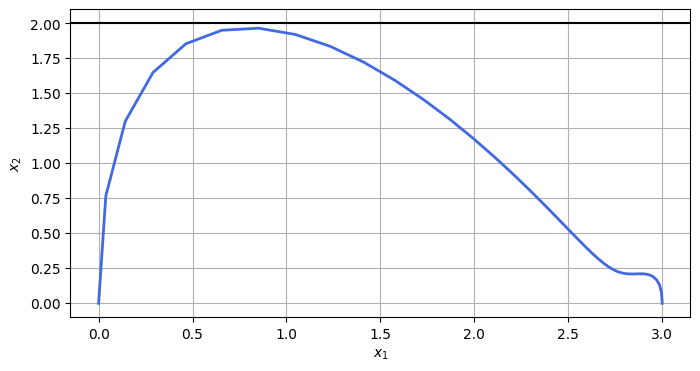

In [5]:
plot_data_nominal = EllipsoidData2D(
    center_data = X_nominal[:,0:nx_system],
    delta = None,
    M = None
)

fig, ax = base_plot(ub_x2=2.0, size=(8,4), lw=1.5)
add_plot_trajectory(ax, plot_data_nominal, center_color = 'royalblue', lw_center=2)
plt.grid()

# Tube-MPC, without GP, open-loop (for computational time comparison)

### Define dynamics and residual model

In [6]:
# Create system and tube dynamics, stack them into a single dynamic, and create an integrator
system_dynamics_no_gp = LinearSystemNoGP(A,B)
max_norm_d_M_no_gp = 0.4    # for the tube dynamics without GP, constant expansion term
tube_dynamics_no_gp = TubeDynamicsNoGP(rho,max_norm_d_M_no_gp)
system_and_tube_dynamics_no_gp = SystemAndTubeDynamicsNoGP(system_dynamics_no_gp,tube_dynamics_no_gp)
system_and_tube_time_integrator_no_gp = TimeIntegrator(system_and_tube_dynamics_no_gp,h)

# Create residual model
residual_model_no_gp = ResidualTimeIntegration(system_and_tube_time_integrator_no_gp)

### Solve optimisation problem (open loop, 1 single solve)

In [7]:
ocp_no_gp = export_ocp_MSDS_RMPC(N, T, constants_offline, initial_con_z=False, terminal_con=True, soft_con=False, z_ref=np.array([3.0,0.]))
ocp_no_gp.model.name = 'msds_no_gp_v1'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_no_gp.solver_options.integrator_type = "DISCRETE"
ocp_no_gp.solver_options.globalization='MERIT_BACKTRACKING'
ocp_no_gp.solver_options.line_search_use_sufficient_descent=1
ocp_no_gp.solver_options.levenberg_marquardt = 1.
ocp_no_gp.solver_options.nlp_solver_max_iter = 100

# initialise solver
start_time_init_no_gp = timeit.default_timer()
zoro_no_gp = ResidualLearningMPC(
    copy.deepcopy(ocp_no_gp),
    residual_model=residual_model_no_gp,
    use_cython=False,
    path_json_ocp=ocp_no_gp.model.name + '.json',
    build_c_code=True
)

X_init = np.zeros((N+1, system_and_tube_dynamics_no_gp.nx))
U_init = np.ones((N, system_and_tube_dynamics_no_gp.nu))

for i in range(N):
    zoro_no_gp.ocp_solver.set(i, "x", X_init[i,:])
    zoro_no_gp.ocp_solver.set(i, "u", U_init[i,:])
       
zoro_no_gp.ocp_solver.set(N, "x", X_init[N,:])
zoro_no_gp.p_hat_nonlin[0, :] = np.array([0.,0.])

duration_init_no_gp = timeit.default_timer() - start_time_init_no_gp
print('Duration solver initialisation: {:.2f} s'.format(duration_init_no_gp))

# solve optimisation problem
start_time_solve_no_gp = timeit.default_timer()
zoro_no_gp.solve(n_iter_max=100,tol_nlp=1e-05)
X_no_gp, U_no_gp = zoro_no_gp.get_solution()
duration_solve_no_gp = timeit.default_timer() - start_time_solve_no_gp
print('Duration optimiser solution: {:.2f} s'.format(duration_solve_no_gp))

       Type of constraints: Hard constraints
 Initial stage constraints: Present, without explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_msds_no_gp_v1.so
rm -f msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_0_fun_jac_uxt_zt.o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_0_fun.o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_fun_jac_uxt_zt.o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_fun.o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_e_fun_jac_uxt_zt.o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_e_fun.o acados_solver_msds_no_gp_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o msds_no_gp_v1_constraints/msds_no_gp_v1_constr_h_0_fun_jac_uxt_zt.o msds_no_gp_v1_constraints/msds_no_gp_v1_c

### Plot results

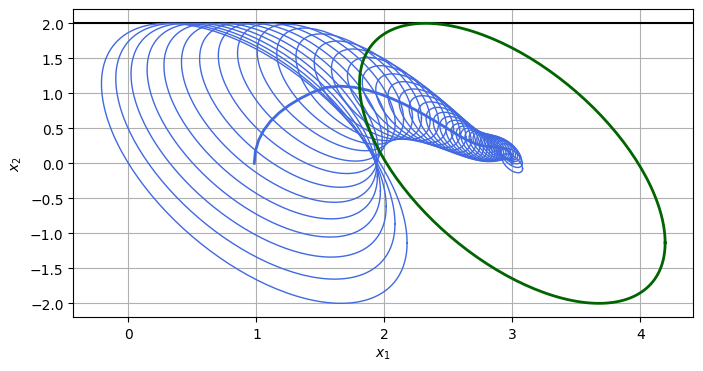

In [8]:
plot_data_no_gp = EllipsoidData2D(
    center_data = X_no_gp[:,0:nx_system],
    delta = X_no_gp[:,nx_system],
    M = M
)

plot_terminal_set = EllipsoidData2D(
    center_data = np.array([[3.0,0.0]]),  # reference state
    delta = np.array([constants_offline['delta_bar_0']]),
    M = M
)

fig, ax = base_plot(ub_x2=2.0, size=(8,4), lw=1.5)
add_plot_trajectory(ax, plot_data_no_gp, center_color = 'royalblue', tube_color = 'royalblue', lw_center=2, lw_tube=1)
add_plot_trajectory(ax, plot_terminal_set, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=0.1, lw_tube=2)
plt.grid()

# Train GP model offline

### Get offline data

In [7]:
# Define offline training points (inputs)
start_x_offline = 0
stop_x_offline = 1.0
n_offline_data = 10
x_train_offline = torch.linspace(start_x_offline, stop_x_offline, n_offline_data)
x_train_offline = x_train_offline.unsqueeze(1)  # tensor of size (n_offline_data,1)
n_GP_inputs = x_train_offline.shape[1]

# Generate observation at training inputs
# Note: the function g_eval only takes the states defined in x_train_offline as inputs
noise_size = 0.001
y_train_offline = generate_g_outputs_at_training_inputs(g_eval, x_train_offline, noise_size)

# Prepare for batch GP
X_train_batch = torch.zeros((n_gp_models_in_batch, n_data_points_in_batch, 1))
Y_train_batch = torch.full((n_gp_models_in_batch, n_data_points_in_batch), float('nan'))

# Copy the original data into the new tensors
X_train_batch[:, :n_offline_data, :] = x_train_offline.tile(n_gp_models_in_batch, 1, 1) # size of training data (X) for the batch is (n_gp_models_in_batch, n_data_points_in_batch, n_GP_inputs)
Y_train_batch[:, :n_offline_data] = y_train_offline.tile(n_gp_models_in_batch, 1)       # size of training data (Y) for the batch is (n_gp_models_in_batch, n_data_points_in_batch)
batch_shape = torch.Size([n_gp_models_in_batch])

### Train model

In [8]:
# Initialize likelihood and model
torch.manual_seed(0)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape)  
gp_models_as_batch = BatchGPModel(X_train_batch, Y_train_batch, likelihood, batch_shape)

# Train the batch model 
gp_models_as_batch, likelihood = train_GP_models_as_batch_with_nan(gp_models_as_batch, likelihood, X_train_batch, Y_train_batch, training_iterations = 100)

# Set all hyperparameters to be the same for all GP in the batch
gp_models_as_batch, likelihood = set_hyperparameters_to_first_dimension(gp_models_as_batch, likelihood)

# Print hyperparameters (all GP models sould have the same hyperparameters)
# print_hyperparameters_of_batch(gp_models_as_batch,likelihood)

# Set the model to evaluation mode
gp_models_as_batch.eval()
likelihood.eval()

Iter 1/100 - Loss: 0.900
Iter 2/100 - Loss: 0.861
Iter 3/100 - Loss: 0.820
Iter 4/100 - Loss: 0.779
Iter 5/100 - Loss: 0.738
Iter 6/100 - Loss: 0.696
Iter 7/100 - Loss: 0.653
Iter 8/100 - Loss: 0.610
Iter 9/100 - Loss: 0.566
Iter 10/100 - Loss: 0.522
Iter 11/100 - Loss: 0.477
Iter 12/100 - Loss: 0.432
Iter 13/100 - Loss: 0.387
Iter 14/100 - Loss: 0.340
Iter 15/100 - Loss: 0.294
Iter 16/100 - Loss: 0.247
Iter 17/100 - Loss: 0.199
Iter 18/100 - Loss: 0.151
Iter 19/100 - Loss: 0.103
Iter 20/100 - Loss: 0.055
Iter 21/100 - Loss: 0.006
Iter 22/100 - Loss: -0.043
Iter 23/100 - Loss: -0.093
Iter 24/100 - Loss: -0.142
Iter 25/100 - Loss: -0.192
Iter 26/100 - Loss: -0.242
Iter 27/100 - Loss: -0.293
Iter 28/100 - Loss: -0.343
Iter 29/100 - Loss: -0.393
Iter 30/100 - Loss: -0.444
Iter 31/100 - Loss: -0.494
Iter 32/100 - Loss: -0.545
Iter 33/100 - Loss: -0.595
Iter 34/100 - Loss: -0.645
Iter 35/100 - Loss: -0.696
Iter 36/100 - Loss: -0.746
Iter 37/100 - Loss: -0.796
Iter 38/100 - Loss: -0.845
Iter

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

### Plot initial GP models

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


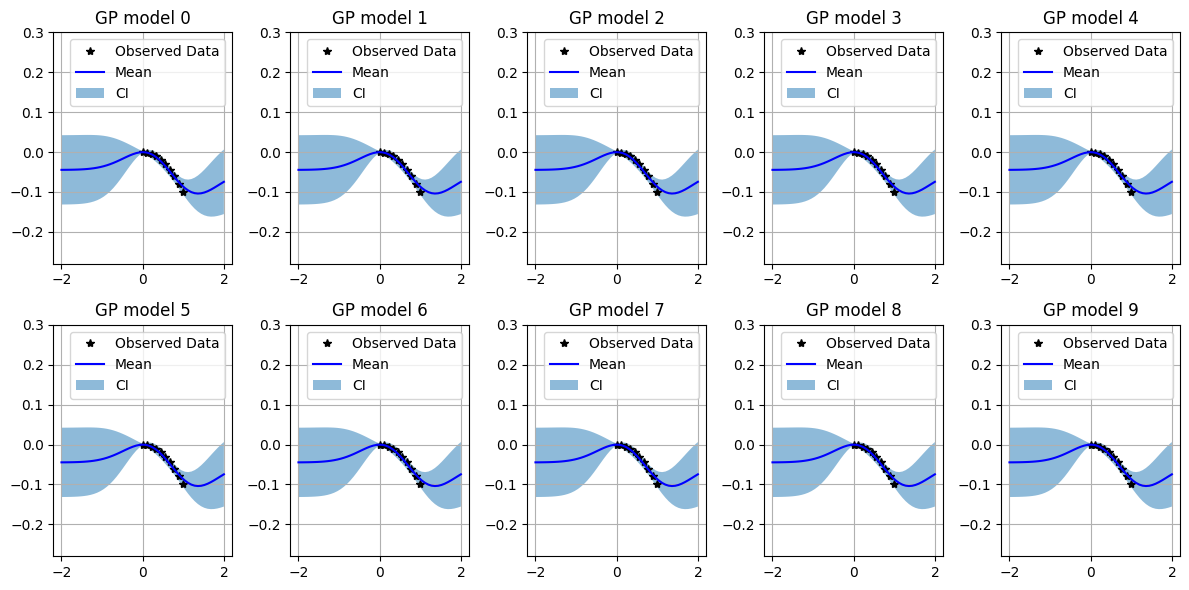

In [11]:
# Plot all GP models in the batch
_, _ = plot_gp_models_in_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, X_train_batch, Y_train_batch, ylim=(-0.28,0.3), figsize=(12,6))

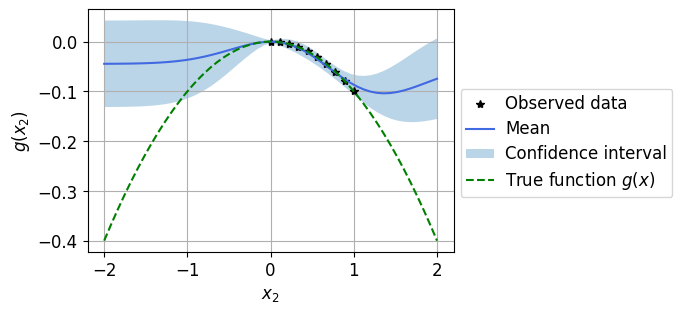

In [12]:
# Initial GP model alone, figure for the report
fig, ax = plot_single_gp_from_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, X_train_batch, Y_train_batch, g_eval, 
                                       figsize=(12*cm,8*cm), x_label='$x_2$', y_label='$g(x_2)$',
                                       legend_size=12, ax_label_size=12,tick_size=12)
# plt.savefig('gp_offline.pdf', bbox_inches='tight')

# RMPC, with GP, open-loop 

### Define residual model (with GP, trained on offline data)

In [17]:
# Define system dynamics with GP 
system_dynamics_g_bar = LinearSystemGP(A,B,G)
tube_dynamics_w = TubeDynamicsGP(rho, L_G, G_M, E_M, beta)
single_GP_est_model = EstimateAndBoundSingleGP(gp_models_as_batch, beta, g_sys_state_idx)
system_and_tube_dynamics_RMPC = SystemAndTubeDynamicsGP(system_dynamics_g_bar, tube_dynamics_w, single_GP_est_model)
time_integrator_RMPC = TimeIntegrator(system_and_tube_dynamics_RMPC,h)

# Create residual with GP
residual_model_RMPC = ResidualTimeIntegration(time_integrator_RMPC)   

### Solve optimisation problem (open loop,1 single solve)

In [14]:
ocp_RMPC_ol = export_ocp_MSDS_RMPC(N, T, constants_offline, initial_con_z=True, terminal_con=True, soft_con=False, z_ref=np.array([4.0,0.]))
ocp_RMPC_ol.model.name = 'msds_with_gp_v1'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RMPC_ol.solver_options.integrator_type = "DISCRETE"
ocp_RMPC_ol.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RMPC_ol.solver_options.levenberg_marquardt = 1.
ocp_RMPC_ol.solver_options.line_search_use_sufficient_descent=1
ocp_RMPC_ol.solver_options.nlp_solver_max_iter = 100

# initialise solver
start_time_init_RMPC_ol = timeit.default_timer()
zoro_RMPC_ol = ResidualLearningMPC(
    copy.deepcopy(ocp_RMPC_ol),
    residual_model=residual_model_RMPC,
    use_cython=False,
    path_json_ocp=ocp_RMPC_ol.model.name + '.json',
    build_c_code=True
)

X_init = np.zeros((N+1, nx_system+1))
U_init = np.ones((N, nu_system))

for i in range(N):   
    zoro_RMPC_ol.ocp_solver.set(i, "x", X_init[i,:])
    zoro_RMPC_ol.ocp_solver.set(i, "u", U_init[i,:])
zoro_RMPC_ol.ocp_solver.set(N, "x", X_init[N,:])
zoro_RMPC_ol.p_hat_nonlin[0, :] = np.array([0.0, 0.0])

duration_init_RMPC_ol = timeit.default_timer() - start_time_init_RMPC_ol
print('Duration solver initialisation: {:.2f} s'.format(duration_init_RMPC_ol))

# solve optimisation problem
start_time_solve_RMPC_ol = timeit.default_timer()
zoro_RMPC_ol.solve(n_iter_max=50,tol_nlp=1e-05)
X_RMPC_ol,U_RMPC_ol = zoro_RMPC_ol.get_solution()
duration_solve_RMPC_ol = timeit.default_timer() - start_time_solve_RMPC_ol
print('Duration optimiser solution: {:.2f} s'.format(duration_solve_RMPC_ol))

       Type of constraints: Hard constraints
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_msds_with_gp_v1.so
rm -f msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_0_fun_jac_uxt_zt.o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_0_fun.o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_fun_jac_uxt_zt.o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_fun.o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_e_fun_jac_uxt_zt.o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_e_fun.o acados_solver_msds_with_gp_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o msds_with_gp_v1_constraints/msds_with_gp_v1_constr_h_0_fun_jac_uxt_zt.o msds_with_gp

### Simulate closed-loop real system based on open-loop optimal inputs

In [15]:
# Create real system dyanmics object
real_system_dynamics = LinearSystemReal(A,B,G,g, E=E, d_bounds=torch.tensor([np.array(d_max)]).float())
# Initiate solution
X_real_system_cl_RMPC = np.zeros((N+1,nx_system))

# Simulate
for k in range(N):
    x_k = torch.tensor(np.float32(X_real_system_cl_RMPC[k,:])).unsqueeze(0) # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(X_RMPC_ol[k,:nx_system])).unsqueeze(0)    # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_RMPC_ol[k,0:nu_system])).unsqueeze(0)   # optimal input we just found for the first stage, shape (1,nu)
    x_next = simulate_real_system_RK4_1_sn_const_K_RMPC(real_system_dynamics, system_dynamics_g_bar, single_GP_est_model, g_sys_state_idx, 
                                                        x_k, z_k, v_k, torch.tensor(np.float32(K)), h)
    X_real_system_cl_RMPC[k+1,:] = x_next.detach().squeeze().numpy()

/tmp/ipykernel_488058/3898274838.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  real_system_dynamics = LinearSystemReal(A,B,G,g, E=E, d_bounds=torch.tensor([np.array(d_max)]).float())


### Plot results

(-2.15, 2.15)

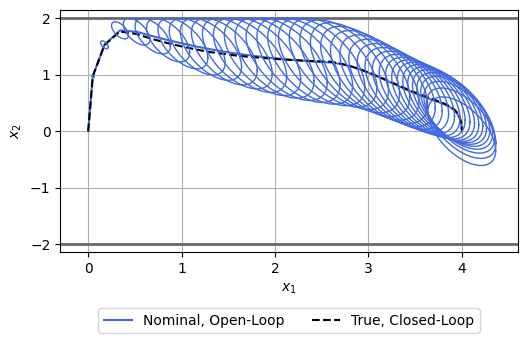

In [16]:
plot_data_RMPC_ol = EllipsoidData2D(
    center_data = X_RMPC_ol[:,0:2],
    delta = X_RMPC_ol[:,2],
    M = constants_offline['M']
)

plot_data_real_system = EllipsoidData2D(
    center_data = X_real_system_cl_RMPC[:,:],
    delta = None,
    M = None
)

fig, ax = base_plot(ub_x2=2.0, lb_x2=-2.0, size=(15*cm,8*cm), lw=2.0, color='dimgrey')
h1 = add_plot_trajectory(ax, plot_data_RMPC_ol, center_color = 'royalblue', tube_color = 'royalblue', lw_center=1.5, lw_tube=1)
h2 = add_plot_trajectory(ax, plot_data_real_system,  center_color = 'k', center_linestyle='--',lw_center=1.5)
lgd = ax.legend([h1[0], h2[0]], ['Nominal, Open-Loop', 'True, Closed-Loop'], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.grid()
plt.xlim(-0.3,4.6)
plt.ylim(-2.15,2.15)

# fig.savefig('RMPC_with_true_sys_z0_2.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')  


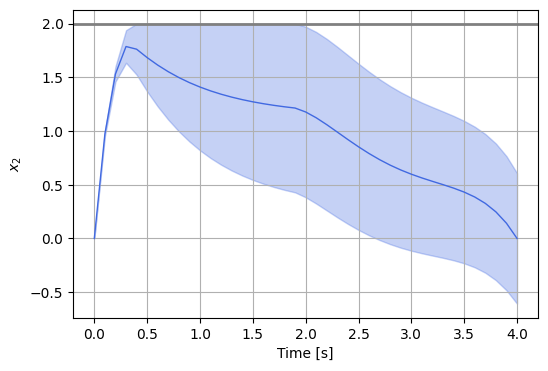

In [17]:
# plot x_2 across time
fig,ax = plot_single_state(X_RMPC_ol[:,1],N,h,'$x_2$', c=c_x[1], delta=X_RMPC_ol[:,2], color_tube='royalblue', alpha_tube=0.3)
ax.axhline(2.0, lw=2.0, color='grey')
plt.show()

# RMPC, with GP, closed-loop

### Define real system dynamics

In [15]:
# Create real system dyanmics object
real_system_dynamics = LinearSystemReal(A,B,G,g,E=E,d_bounds=torch.tensor([np.array(d_max)]).float())

### Solver closed-loop MPC problem

In [18]:
# define constants
ocp_RMPC_cl = export_ocp_MSDS_RMPC(N, T, constants_offline, initial_con_z=True, terminal_con=True, soft_con=False)
ocp_RMPC_cl.model.name = 'msds_with_gp_cl_v1'


# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RMPC_cl.solver_options.integrator_type = "DISCRETE"
ocp_RMPC_cl.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RMPC_cl.solver_options.levenberg_marquardt = 1.
ocp_RMPC_cl.solver_options.line_search_use_sufficient_descent=1
ocp_RMPC_cl.solver_options.nlp_solver_max_iter = 100

# define some constants
n_sim = 40   # set to 5 to obtain the first simulation steps only
nx_ocp_RMPC = system_and_tube_dynamics_RMPC.nx
nu_ocp_RMPC = system_and_tube_dynamics_RMPC.nu

# store results
x_sim_store_RMPC = np.zeros((nx_system,n_sim+1))  
z_sim_store_RMPC = np.zeros((nx_system,n_sim+1))
sol_state_full_store_RMPC = np.zeros((n_sim,N+1,system_and_tube_dynamics_RMPC.nx)) 
comp_time_list = [] 
n_iter_list = []
comp_time_per_SQP_list = []
comp_time_tot_list_RMPC = []

# initialise solver
zoro_RMPC_cl = ResidualLearningMPC(
    copy.deepcopy(ocp_RMPC_cl),
    residual_model=residual_model_RMPC,
    use_cython=False,
    path_json_ocp=ocp_RMPC_cl.model.name + '.json',
    build_c_code=True
)

# set initial solution candidate/guess
X_init = np.zeros((N+1, nx_ocp_RMPC))
U_init = np.ones((N, nu_ocp_RMPC))

for k in range(n_sim):

    print('Solving step nr. {}/{}'.format(k,n_sim-1))  
    
    # set solver parameters
    for i in range(N):   
        zoro_RMPC_cl.ocp_solver.set(i, "x", X_init[i,:])
        zoro_RMPC_cl.ocp_solver.set(i, "u", U_init[i,:])
    zoro_RMPC_cl.ocp_solver.set(N, "x", X_init[N,:])
    zoro_RMPC_cl.p_hat_nonlin[0, :] = x_sim_store_RMPC[:,k] 
    # print(zoro_solver_with_gp.p_hat_nonlin[0, :])

    # solve
    start_time_solve_k = timeit.default_timer()
    zoro_RMPC_cl.solve(n_iter_max=100,tol_nlp=1e-05)

    # store computational time
    duration_solve_k = timeit.default_timer() - start_time_solve_k
    print('Duration optimiser solution: {:.2f} s'.format(duration_solve_k))
    comp_time_list.append(duration_solve_k)
    n_iter_k = zoro_RMPC_cl.solve_stats['n_iter']
    n_iter_list.append(n_iter_k)
    comp_time_per_SQP_list.append(duration_solve_k/n_iter_k)
    comp_time_tot_list_RMPC.append(duration_solve_k)
    

    # get and store solution
    X_sol_k,U_sol_k = zoro_RMPC_cl.get_solution()
    sol_state_full_store_RMPC[k,:,:] = X_sol_k 
    z_sim_store_RMPC[:,k] = X_sol_k[0,0:nx_system]

    # simulate real model over one sampling interval dt
    x_k = torch.tensor(np.float32(x_sim_store_RMPC[:,k])).unsqueeze(0)           # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(z_sim_store_RMPC[:,k])).unsqueeze(0)           # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_sol_k[0,0:nu_system])).unsqueeze(0)     # optimal input we just found for the first stage, shape (1,nu)
    lambda_k = torch.tensor(np.float32(U_sol_k[0,nu_system:])).unsqueeze(0) # optimal lambdas we just found for the first stage, shape (1,n_gp_models_in_batch)
    
    x_next = simulate_real_system_RK4_1_sn_const_K_RMPC(real_system_dynamics, system_dynamics_g_bar, single_GP_est_model, g_sys_state_idx, x_k, z_k, v_k, torch.tensor(np.float32(K)), h)
    x_sim_store_RMPC[:,k+1] = x_next.detach().squeeze().numpy()

    # shift candidate solution for next solve
    X_init[:-1, :] = X_sol_k[1:, :]
    X_init[-1, :] = X_sol_k[-1, :]
    U_init[:-1, :] = U_sol_k[1:, :]
    U_init[-1, :] = U_sol_k[-1, :]

print('computational time per SQP iteration: ', comp_time_per_SQP_list)
print('Average:', np.mean(np.array(comp_time_per_SQP_list)))
comp_time_RMPC_cl = comp_time_per_SQP_list

       Type of constraints: Hard constraints
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present
rm -f libacados_ocp_solver_msds_with_gp_cl_v1.so
rm -f msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_0_fun_jac_uxt_zt.o msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_0_fun.o msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_fun_jac_uxt_zt.o msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_fun.o msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_e_fun_jac_uxt_zt.o msds_with_gp_cl_v1_constraints/msds_with_gp_cl_v1_constr_h_e_fun.o acados_solver_msds_with_gp_cl_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o msds_with_gp_cl_v1_constraints/msds_with_g

### Plot results

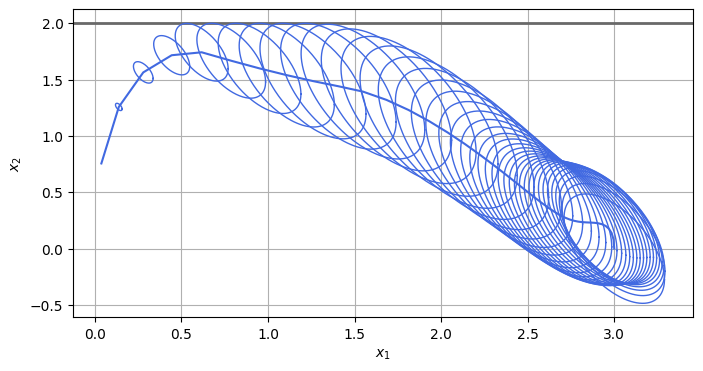

In [20]:
# Choose which solution (at which simulation step) to plot
X_sol_to_plot = sol_state_full_store_RMPC[1,:,:]

# Plot solution in the p1-p2 plane (position)
plot_data_RMPC = EllipsoidData2D(
    center_data = X_sol_to_plot[:,0:2],
    delta = X_sol_to_plot[:,2],
    M = M    
)
plot_data_true_sys_sim_RMPC= EllipsoidData2D(
    center_data = np.transpose(x_sim_store_RMPC[0:2,:]),
    delta = None,
    M = None   
)

fig, ax = base_plot(ub_x2=2.0, size=(8,4), lw=2.0, color='dimgrey')
h1 = add_plot_trajectory(ax, plot_data_RMPC, center_color = 'royalblue', tube_color = 'royalblue', lw_center=1.5, lw_tube=1)
# h1 = add_plot_trajectory(ax, plot_data_true_sys_sim_RMPC, center_color = 'royalblue',  lw_center=1.5)
plt.grid()

# RAMPC, with GP, closed loop

### Define real system dynamics (used for closed-loop simulation)

In [9]:
# Create real system dyanmics object
real_system_dynamics = LinearSystemReal(A,B,G,g,E=E,d_bounds=torch.tensor([np.array(d_max)]).float())

/tmp/ipykernel_566635/892196031.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  real_system_dynamics = LinearSystemReal(A,B,G,g,E=E,d_bounds=torch.tensor([np.array(d_max)]).float())


### Define residual model (with GP, trained on offline data)

In [10]:
# Define nominal systme
system_dynamics_g_bar = LinearSystemGP(A,B,G)
tube_dynamics_w = TubeDynamicsGP(rho, L_G, G_M, E_M, beta)
gp_beta_list = [beta for number in range(n_gp_models_in_batch)] #torch.tensor([20.]).repeat(n_gp_models_in_batch)
active_gp_idx = [0] # only the first GP of the batch is used/active at the beginning
x_train_standard_format = x_train_offline   # size is (n_offline_data,1)
y_train_standard_format = y_train_offline   # size is (n_offline_data)
n_training_data_points = n_offline_data
multi_lambda_est_model = EstimateAndBoundMultiLambda(gp_models_as_batch, gp_beta_list, active_gp_idx, g_sys_state_idx) 
system_and_tube_dynamics_gw_bar_multi_lambda = SystemAndTubeDynamicsGPMultiLambda(system_dynamics_g_bar, tube_dynamics_w, multi_lambda_est_model)
time_integrator_gw_bar_multi_lambda = TimeIntegrator(system_and_tube_dynamics_gw_bar_multi_lambda,h)

eliminate_GP_if_possible =  True # True: will eliminate GP models in batch if no needed for optimal solution. False: will keep all GP models
time_integrator_gw_bar_multi_lambda.is_eliminate_GP = eliminate_GP_if_possible  

# Create residual with GP
residual_model_gw_bar_multi_lambda = ResidualTimeIntegration(time_integrator_gw_bar_multi_lambda)   

ocp_RAMPC = export_ocp_MSDS_RAMPC(N, T, constants_offline,n_gp_models_in_batch, initial_con_z=True, terminal_con=True, soft_con=False)
ocp_RAMPC.model.name = 'msds_RAMPC_v1'

# OCP is discretized inside zoRO solver, so we need to choose DISCRETE integration here
ocp_RAMPC.solver_options.integrator_type = "DISCRETE"
ocp_RAMPC.solver_options.globalization='MERIT_BACKTRACKING'
ocp_RAMPC.solver_options.levenberg_marquardt = 1.
ocp_RAMPC.solver_options.line_search_use_sufficient_descent=1
ocp_RAMPC.solver_options.nlp_solver_max_iter = 100

       Type of constraints: Hard constraints
 Initial stage constraints: Present, with explicit constraints on z
Terminal stage constraints: Present


### Solve closed-loop problem

In [11]:
# define constants
n_sim = 40  # set to 5 to obtain the first simulation steps only
nx_ocp_RAMPC = system_and_tube_dynamics_gw_bar_multi_lambda.nx
nu_ocp_RAMPC = system_and_tube_dynamics_gw_bar_multi_lambda.nu
tol_lambda_elimination = 0.01

# store results
x_sim_store_RAMPC = np.zeros((nx_system,n_sim+1))  
z_sim_store_RAMPC = np.zeros((nx_system,n_sim+1))
sol_state_full_store_RAMPC = np.zeros((n_sim,N+1,system_and_tube_dynamics_gw_bar_multi_lambda.nx)) 
comp_time_list = [] 
n_iter_list = []
comp_time_per_SQP_list_RAMPC = []
comp_time_tot_list_RAMPC = []

# initialise solver
zoro_RAMPC = ResidualLearningMPC(
    copy.deepcopy(ocp_RAMPC),
    residual_model=residual_model_gw_bar_multi_lambda,
    use_cython=False,
    path_json_ocp=ocp_RAMPC.model.name + '.json',
    build_c_code=True
)

# set initial solution candidate/guess
X_init = np.zeros((N+1, nx_ocp_RAMPC))
U_init = np.ones((N, nu_ocp_RAMPC))

for k in range(n_sim):

    print('Solving step nr. {}/{}'.format(k,n_sim-1))  
    
    # set solver parameters
    for i in range(N):   
        zoro_RAMPC.ocp_solver.set(i, "x", X_init[i,:])
        zoro_RAMPC.ocp_solver.set(i, "u", U_init[i,:])
    zoro_RAMPC.ocp_solver.set(N, "x", X_init[N,:])
    zoro_RAMPC.p_hat_nonlin[0, :] = x_sim_store_RAMPC[:,k] 
    print(zoro_RAMPC.p_hat_nonlin[0, :])

    # solve
    start_time_solve_k = timeit.default_timer()
    zoro_RAMPC.solve(n_iter_max=100,tol_nlp=1e-5)

    # store computational time
    duration_solve_k = timeit.default_timer() - start_time_solve_k
    print('Duration optimiser solution: {:.2f} s'.format(duration_solve_k))
    comp_time_list.append(duration_solve_k)
    n_iter_k = zoro_RAMPC.solve_stats['n_iter']
    n_iter_list.append(n_iter_k)
    comp_time_per_SQP_list_RAMPC.append(duration_solve_k/n_iter_k)
    comp_time_tot_list_RAMPC.append(duration_solve_k)

    # get and store solution
    X_sol_k,U_sol_k = zoro_RAMPC.get_solution()
    sol_state_full_store_RAMPC[k,:,:] = X_sol_k 
    z_sim_store_RAMPC[:,k] = X_sol_k[0,0:nx_system]

    # simulate real model over one sampling interval dt
    x_k = torch.tensor(np.float32(x_sim_store_RAMPC[:,k])).unsqueeze(0)           # current real state, shape (1,nx), one single shooting node
    z_k = torch.tensor(np.float32(z_sim_store_RAMPC[:,k])).unsqueeze(0)           # current nominal state, shape (1,nx), one single shooting node
    v_k = torch.tensor(np.float32(U_sol_k[0,0:nu_system])).unsqueeze(0)     # optimal input we just found for the first stage, shape (1,nu)
    lambda_k = torch.tensor(np.float32(U_sol_k[0,nu_system:])).unsqueeze(0) # optimal lambdas we just found for the first stage, shape (1,n_gp_models_in_batch)
    
    x_next = simulate_real_system_RK4_1_sn_const_K(real_system_dynamics, system_dynamics_g_bar, multi_lambda_est_model, g_sys_state_idx, x_k, z_k, v_k, lambda_k, torch.tensor(np.float32(K)), h)
    x_sim_store_RAMPC[:,k+1] = x_next.detach().squeeze().numpy()

    # eliminate GP model if not used/needed
    if time_integrator_gw_bar_multi_lambda.is_eliminate_GP == True:
        # define useful list of indexes
        gp_model_all_idx = range(n_gp_models_in_batch)
        gp_model_idx_to_eliminate = []
    
        # reshape for looking at potential patterns: 4xN - 4 RK4 evalutations over N steps
        rk_reshape = 4
        w_bar_used_gp_models = np.array(zoro_RAMPC.residual_model.system_time_integrator.w_bar_gp_idx_list).reshape(rk_reshape,N)
        # print(w_bar_used_gp_models)

        # loop over gp models and check if conditions are fulfilled
        for i in range(n_gp_models_in_batch):
            # condition 0: index i is corresponding to a GP model that can be used, and not a placholder in the batch
            if i in multi_lambda_est_model.active_gp_idx:
                # condition 1: not used in w_bar evaluation
                if not (i in zoro_RAMPC.residual_model.system_time_integrator.w_bar_gp_idx_list):
                    # condition 2: corresponding lambda value always 0 (i.e., GP model not used for estimate \bar{g})
                    lambda_values_index_i = U_sol_k[:,nu_system + i]
                    if np.all(lambda_values_index_i<=tol_lambda_elimination):
                        gp_model_idx_to_eliminate.append(i)
                        print('---------------')
                        print('GP at position ', i, ' can be eliminated')
                        print('---------------')

    
        # eliminate gp models not used in our gp models' collection
        active_gp_idx = [i for i in multi_lambda_est_model.active_gp_idx if i not in gp_model_idx_to_eliminate]

    # acquire new data point based on system's evolution
    x_new = x_next[g_sys_state_idx]
    x_new = x_new.clone().detach().unsqueeze(1)
    g_new = generate_g_outputs_at_training_inputs(g_eval, x_new, noise_size)
    print('New data point aquired, g_new=')
    print(g_new)
    x_train_standard_format = torch.cat((x_new,x_train_standard_format))
    y_train_standard_format = torch.cat((g_new,y_train_standard_format))
    n_training_data_points += 1

    # train/obtain new GP model
    free_indexes_in_batch = [i for i in range(n_gp_models_in_batch) if i not in active_gp_idx]  # obtain batch indexes of unactive GP models
    if not free_indexes_in_batch:
        print("No free spot in the GP batch. Continue without adding any new GP model ...")
    else:
        idx_new_gp_model = min(free_indexes_in_batch)
        print("Add new GP model at batch position ", idx_new_gp_model)
        X_train_batch[idx_new_gp_model,:n_training_data_points,:] = x_train_standard_format
        Y_train_batch[idx_new_gp_model,:n_training_data_points] = y_train_standard_format
        gp_models_as_batch.set_train_data(inputs=X_train_batch, targets=Y_train_batch)

        # update active GP models' collection
        active_gp_idx.append(idx_new_gp_model)

    # update residual model with new GP models' collection
    multi_lambda_est_model = EstimateAndBoundMultiLambda(gp_models_as_batch, gp_beta_list, active_gp_idx, g_sys_state_idx)
    print('Number of active GP: ', multi_lambda_est_model.n_active_gp)
    system_and_tube_dynamics_gw_bar_multi_lambda = SystemAndTubeDynamicsGPMultiLambda(system_dynamics_g_bar, tube_dynamics_w, multi_lambda_est_model)
    time_integrator_gw_bar_multi_lambda = TimeIntegrator(system_and_tube_dynamics_gw_bar_multi_lambda,h)
    time_integrator_gw_bar_multi_lambda.is_eliminate_GP = eliminate_GP_if_possible
    residual_model_gw_bar_multi_lambda = ResidualTimeIntegration(time_integrator_gw_bar_multi_lambda)  
    zoro_RAMPC.residual_model = residual_model_gw_bar_multi_lambda

    # shift candidate solution for next solve
    X_init[:-1, :] = X_sol_k[1:, :]
    X_init[-1, :] = X_sol_k[-1, :]
    U_init[:-1, :] = U_sol_k[1:, :]
    U_init[-1, :] = U_sol_k[-1, :]

print('computational time per SQP iteration: ', comp_time_per_SQP_list_RAMPC)
print('Average:', np.mean(np.array(comp_time_per_SQP_list_RAMPC)))
comp_time_RAMPC = comp_time_per_SQP_list_RAMPC

rm -f libacados_ocp_solver_msds_RAMPC_v1.so
rm -f msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_0_fun_jac_uxt_zt.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_0_fun.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_fun_jac_uxt_zt.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_fun.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_e_fun_jac_uxt_zt.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_e_fun.o acados_solver_msds_RAMPC_v1.o
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/acados -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/blasfeo/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include/hpipm/include  -c -o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_0_fun_jac_uxt_zt.o msds_RAMPC_v1_constraints/msds_RAMPC_v1_constr_h_0_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados/include -I/mnt/c/Users/mathi/Documents/zo-gpmpc/acados

/mnt/c/users/mathi/documents/zo-gpmpc/env/lib/python3.10/site-packages/gpytorch/models/exact_prediction_strategies.py:278: RuntimeWarning: Observation NaN policy 'fill' makes the kernel matrix dense during exact prediction.
  warnings.warn(


residuals after  1 zoro outer iterations:
 [8.98722035e-07 8.88178420e-16 1.16415322e-10 1.33419010e-07]
Maximum relative error with last linearisation: 0.22261261546374692
Average relative error with last linearisation: 0.06983395128263263
residuals after  2 zoro outer iterations:
 [9.86408907e-07 8.88178420e-16 1.16415322e-10 1.47969745e-07]
Maximum relative error with last linearisation: 0.01085645007404583
Average relative error with last linearisation: 0.0007264291441219239
residuals after  3 zoro outer iterations:
 [8.99348726e-07 8.88178420e-16 1.16415322e-10 1.48338193e-07]
Maximum relative error with last linearisation: 1.883082400255739e-05
Average relative error with last linearisation: 4.508885039814519e-06
residuals after  4 zoro outer iterations:
 [9.81433257e-07 4.44089210e-16 1.16415322e-10 1.48340930e-07]
Maximum relative error with last linearisation: 8.72047349228659e-07
Average relative error with last linearisation: 1.756379836265291e-07
Duration optimiser solution

### Plot GP models' collection

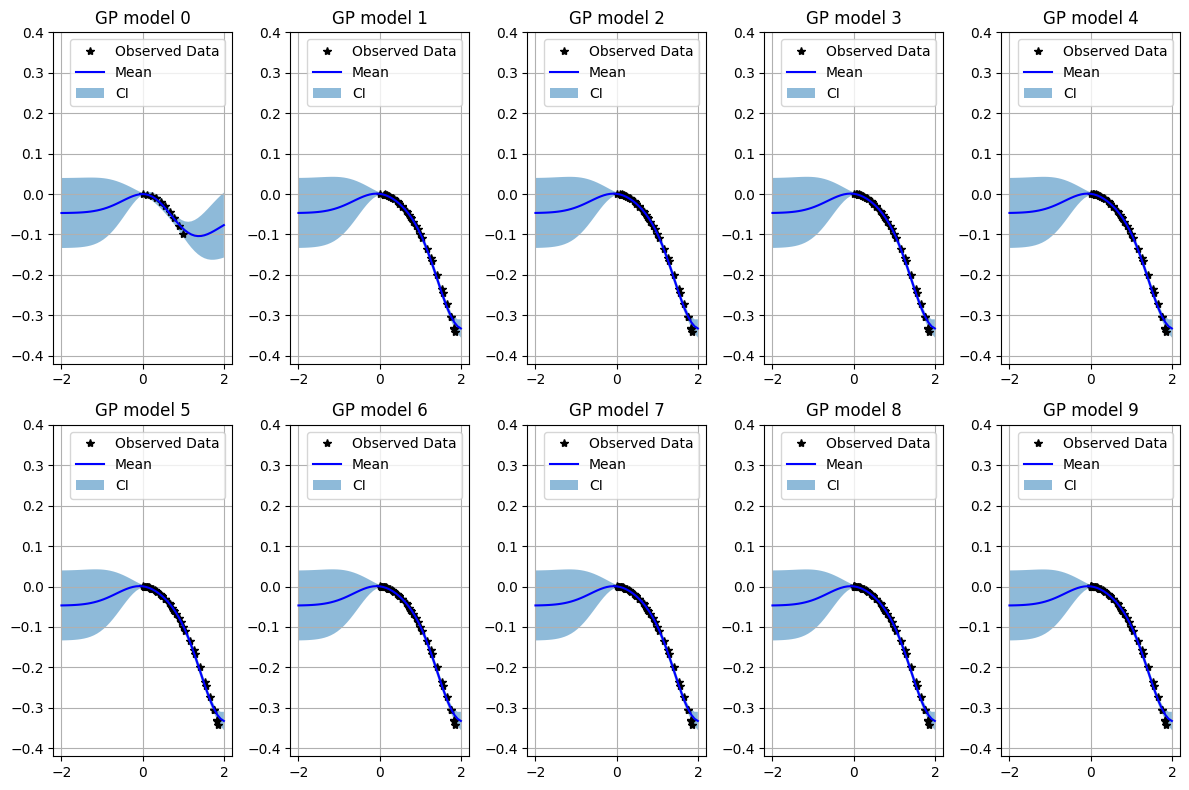

In [12]:
# Plot all GP models in the batch
fig, axes = plot_gp_models_in_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, X_train_batch, Y_train_batch, ylim=(-0.42,0.4), figsize=(12,8)) #n_gp_models_in_batch
# fig.savefig('GP_models.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight') 

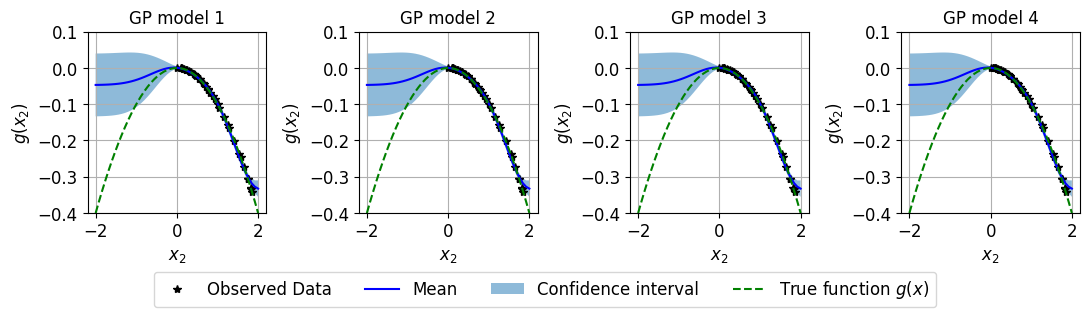

In [13]:
# Only a selection of models (Use option eliminate_GP_if_possible=False to see the first few GP models without eliminitating them)
gp_models_to_plot_idx_list = [1,2,3,4]
fig,_ = plot_gp_models_idx_in_batch_single_input(gp_models_as_batch, n_gp_models_in_batch, gp_models_to_plot_idx_list, X_train_batch, Y_train_batch, g_eval, figsize=(11,3),ylim=(-0.4,0.1))

# fig.savefig('GP_update.pdf', bbox_inches='tight')

### Plot different predictions

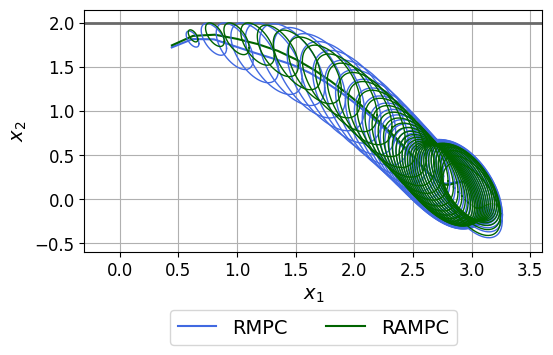

In [19]:
# Choose which solution (at which simulation step) to plot
time_step_to_plot =4
X_sol_to_plot_RAMPC = sol_state_full_store_RAMPC[time_step_to_plot,:,:]

# Plot solution in the p1-p2 plane (position)
plot_data_RAMPC = EllipsoidData2D(
    center_data = X_sol_to_plot_RAMPC[:,0:2],
    delta = X_sol_to_plot_RAMPC[:,2],
    M = M    
)

X_sol_to_plot_RMPC = sol_state_full_store_RMPC[time_step_to_plot,:,:]

# Plot solution in the p1-p2 plane (position)
plot_data_RMPC = EllipsoidData2D(
    center_data = X_sol_to_plot_RMPC[:,0:2],
    delta = X_sol_to_plot_RMPC[:,2],
    M = M    
)

plot_data_true_sys_sim_RAMPC= EllipsoidData2D(
    center_data = np.transpose(x_sim_store_RAMPC[0:2,:]),
    delta = None,
    M = None   
)

fig, ax = base_plot(ub_x2=2.0, lb_x2=-2.0, size=(15*cm,8*cm), lw=2.0, color='dimgrey')
h1 = add_plot_trajectory(ax, plot_data_RMPC, center_color = 'royalblue', tube_color = 'royalblue', lw_center=1.5, lw_tube=1)
h2 = add_plot_trajectory(ax, plot_data_RAMPC, center_color = 'darkgreen', tube_color = 'darkgreen', lw_center=1.5, lw_tube=1)
lgd = ax.legend([h1[0], h2[0]], ['RMPC', 'RAMPC'], 
                loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=14)

plt.grid()
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-0.3,3.6)
plt.ylim(-2.15,2.15)
plt.ylim(-0.6,2.15)

# Save figures
fig.savefig('RAMPC_vs_RMPC_con_z0_step_'+str(time_step_to_plot)+'.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight') 


### Additional plots 

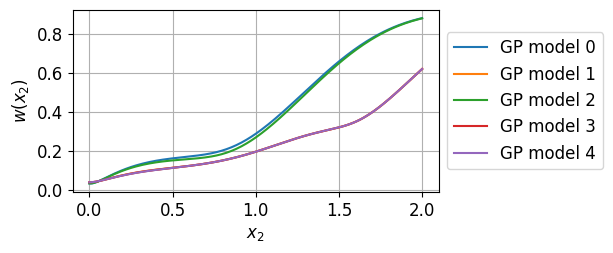

In [27]:
fig,_ = plot_w_bound_idx_list(gp_models_as_batch,0.0,beta,[0,1,2,3,4], figsize=(12*cm,6*cm), legend_size=12, ax_label_size=12, tick_size=12)
fig.savefig('GP_bounds_z0.pdf',bbox_inches='tight') 
